# Multi-Model Market Forecasting & Risk Engine

**Industrial-Grade Two-Step ARIMA-GARCH Implementation**

| Model | Type | Approach |
|-------|------|----------|
| **ARIMA-GARCH** | Econometric | Two-step: ARIMA (statsmodels) → GARCH on residuals |
| **XGBoost** | ML | Lagged features + walk-forward validation |
| **LSTM** | Deep Learning | Sequence-based RNN |

---

## Table of Contents

1. [Setup & Configuration](#setup)
2. [Data Ingestion](#data)
3. **Part A: ARIMA-GARCH** (Two-Step Estimation)
4. **Part B: XGBoost**
5. **Part C: LSTM**
6. **Part D: Consolidated Comparison**

<a id='setup'></a>
## 0. Setup & Configuration

In [91]:
# === GLOBAL CONFIGURATION ===
TICKER = "AAPL"              # Asset to analyze
START_DATE = "2002-01-01"   # Training start
END_DATE = "2024-12-31"     # Training end 
TEST_SIZE = 56              # Out-of-sample test days (~2.5 months)
RANDOM_SEED = 42

# ARIMA Grid Search Constraints
MAX_AR = 4                  # Max AR order (p)
MAX_MA = 4                  # Max MA order (q)
MAX_D = 2                   # Max differencing order for ADF search

# GARCH Constraints
GARCH_P = 1
GARCH_Q = 1
DISTRIBUTIONS = ['normal', 't', 'skewt']
# ============================

In [92]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from itertools import product
import warnings
warnings.filterwarnings('ignore')

load_dotenv()
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['font.size'] = 11

print("✓ All imports successful.")

✓ All imports successful.


<a id='data'></a>
## 1. Data Ingestion & Preprocessing

In [93]:
def fetch_data_alpaca(ticker, start, end):
    try:
        from alpaca_trade_api import REST
        api_key = os.getenv('ALPACA_API_KEY')
        secret_key = os.getenv('ALPACA_SECRET_KEY')
        endpoint = os.getenv('ALPACA_ENDPOINT', 'https://paper-api.alpaca.markets')
        if not api_key or api_key == 'your_api_key_here':
            return None
        api = REST(api_key, secret_key, endpoint)
        bars = api.get_bars(ticker, '1Day', start=start, end=end, adjustment='all').df
        if bars.empty:
            return None
        bars = bars.reset_index()
        bars = bars.rename(columns={'timestamp': 'Date', 'close': 'Price'})
        bars = bars[['Date', 'Price']]
        bars['Date'] = pd.to_datetime(bars['Date']).dt.tz_localize(None)
        bars = bars.set_index('Date')
        print(f"✓ Data from Alpaca: {len(bars)} obs")
        return bars
    except:
        return None

def fetch_data_yfinance(ticker, start, end):
    import yfinance as yf
    raw = yf.download(ticker, start=start, end=end, progress=False, auto_adjust=True)
    if raw.empty:
        raise ValueError(f"No data for {ticker}")
    if isinstance(raw.columns, pd.MultiIndex):
        df = raw['Close'].to_frame()
        df.columns = ['Price']
    else:
        df = raw[['Close']].copy()
        df.columns = ['Price']
    df.index.name = 'Date'
    print(f"✓ Data from yfinance: {len(df)} obs")
    return df

def fetch_data(ticker, start, end):
    print(f"Fetching {ticker} from {start} to {end}...")
    df = fetch_data_alpaca(ticker, start, end)
    if df is None:
        df = fetch_data_yfinance(ticker, start, end)
    return df

In [94]:
df = fetch_data(TICKER, START_DATE, END_DATE)
df['Return'] = np.log(df['Price'] / df['Price'].shift(1))
df.dropna(inplace=True)

print(f"\n✓ Dataset: {len(df)} observations")
print(f"  Range: {df.index[0].date()} to {df.index[-1].date()}")
df.head()

Fetching AAPL from 2002-01-01 to 2024-12-31...
✓ Data from Alpaca: 2264 obs

✓ Dataset: 2263 observations
  Range: 2016-01-05 to 2024-12-31


,Price,Return
Date,,
2016-01-05 05:00:00,23.16,-0.025156
2016-01-06 05:00:00,22.70,-0.020062
2016-01-07 05:00:00,21.75,-0.042751
2016-01-08 05:00:00,21.86,0.005045
2016-01-11 05:00:00,22.21,0.015884


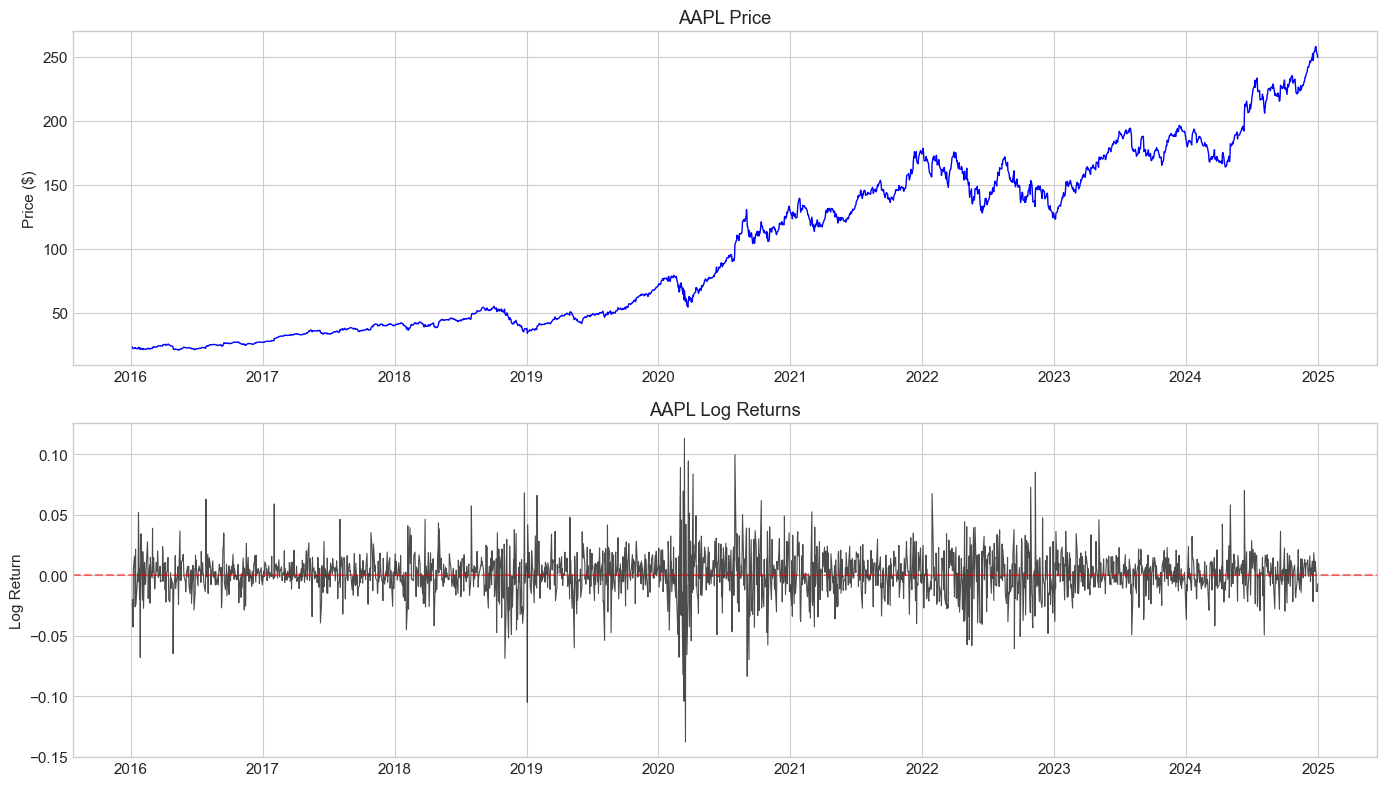

In [95]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))
axes[0].plot(df.index, df['Price'], 'b-', lw=1)
axes[0].set_title(f'{TICKER} Price')
axes[0].set_ylabel('Price ($)')
axes[1].plot(df.index, df['Return'], 'k-', alpha=0.7, lw=0.8)
axes[1].axhline(0, color='red', ls='--', alpha=0.5)
axes[1].set_title(f'{TICKER} Log Returns')
axes[1].set_ylabel('Log Return')
plt.tight_layout()
plt.show()

---
# Part A: ARIMA-GARCH (Two-Step Estimation)

**Methodology:**
1. **Step 1**: Determine `d` via ADF test (iterative)
2. **Step 2**: Grid search ARIMA(p,d,q) using statsmodels → select by AIC
3. **Step 3**: Fit GARCH(1,1) on ARIMA residuals → select distribution by AIC
4. **Step 4**: Diagnostics (Ljung-Box, ARCH-LM)
5. **Step 5**: Walk-forward backtest

### A.1: Stationarity Test & Optimal Differencing Order

In [97]:
def adf_test(series, name='Series', alpha=0.05):
    """Run ADF test and return (is_stationary, p_value, statistic)."""
    s = pd.Series(series).dropna()
    result = adfuller(s, autolag='AIC')
    stat, pval = result[0], result[1]
    print(f"ADF Test: {name}")
    print(f"  Statistic: {stat:.4f}")
    print(f"  p-value:   {pval:.4f}")
    print(f"  Stationary: {'Yes ✓' if pval < alpha else 'No ✗'}")
    return pval < alpha, pval, stat

def find_best_d_by_adf(series, base_name="Series", max_d=3, alpha=0.05):
    """
    Iteratively difference until ADF indicates stationarity.
    Returns (best_d, stationary_series, history).
    """
    s = pd.Series(series).dropna()
    history = []

    print("=" * 50)
    for d in range(0, max_d + 1):
        name = f"{base_name} (d={d})"
        is_stat, pval, stat = adf_test(s, name=name, alpha=alpha)
        history.append({"d": d, "p_value": pval, "stat": stat, "nobs": len(s)})
        print("-" * 50)

        if is_stat:
            print(f"\n✓ Stationary at d={d} (p={pval:.4f}).")
            print("=" * 50)
            return d, s, history

        if d < max_d:
            s = s.diff().dropna()

    print(f"\n⚠ Not stationary up to d={max_d}.")
    print("=" * 50)
    return None, s, history

In [98]:
# Test both Raw Price and Log Returns
print("\n" + "#" * 60)
print("# TESTING RAW PRICE")
print("#" * 60)
d_price, stationary_price, hist_price = find_best_d_by_adf(
    df['Price'], base_name="Raw Price", max_d=MAX_D
)

print("\n" + "#" * 60)
print("# TESTING LOG RETURNS")
print("#" * 60)
d_returns, stationary_returns, hist_returns = find_best_d_by_adf(
    df['Return'], base_name="Log Returns", max_d=MAX_D
)


############################################################
# TESTING RAW PRICE
############################################################
ADF Test: Raw Price (d=0)
  Statistic: 0.5268
  p-value:   0.9857
  Stationary: No ✗
--------------------------------------------------
ADF Test: Raw Price (d=1)
  Statistic: -48.1513
  p-value:   0.0000
  Stationary: Yes ✓
--------------------------------------------------

✓ Stationary at d=1 (p=0.0000).

############################################################
# TESTING LOG RETURNS
############################################################
ADF Test: Log Returns (d=0)
  Statistic: -14.7693
  p-value:   0.0000
  Stationary: Yes ✓
--------------------------------------------------

✓ Stationary at d=0 (p=0.0000).


In [99]:
# Decision: Which series to use for modelling
print("\n" + "=" * 60)
print("SERIES SELECTION FOR MODELLING")
print("=" * 60)

print(f"\nOption 1: Raw Price → requires d={d_price} differencing")
print(f"Option 2: Log Returns → requires d={d_returns} differencing")

# Prefer log returns if stationary at d=0 (no info loss from differencing)
if d_returns == 0:
    USE_SERIES = 'log_returns'
    SERIES_D = 0
    modelling_series = df['Return'].dropna()
    print(f"\n✓ SELECTED: Log Returns (d=0) - already stationary, no data loss")
elif d_price is not None:
    USE_SERIES = 'price'
    SERIES_D = d_price
    modelling_series = stationary_price
    print(f"\n✓ SELECTED: Differenced Price (d={d_price})")
else:
    USE_SERIES = 'log_returns'
    SERIES_D = d_returns if d_returns else 0
    modelling_series = stationary_returns
    print(f"\n✓ SELECTED: Log Returns (d={SERIES_D})")

print(f"\nModelling series length: {len(modelling_series)}")


SERIES SELECTION FOR MODELLING

Option 1: Raw Price → requires d=1 differencing
Option 2: Log Returns → requires d=0 differencing

✓ SELECTED: Log Returns (d=0) - already stationary, no data loss

Modelling series length: 2263


### A.2: ARIMA(p,d,q) Grid Search (Step 1 of Two-Step)

Using `statsmodels.tsa.arima.model.ARIMA` for the mean equation.

In [100]:
def fit_arima(series, order):
    """Fit ARIMA(p,d,q) and return (fit_result, AIC) or (None, inf) on failure."""
    try:
        model = ARIMA(series, order=order, trend="n") 
        fit = model.fit()
        return fit, fit.aic
    except:
        return None, np.inf

In [101]:
# Grid Search over ARIMA(p, d, q)
# Note: d is fixed from ADF test, but we include d=0 since we're using log returns
arima_results = []

print(f"ARIMA Grid Search: p ∈ [0,{MAX_AR}], d={SERIES_D}, q ∈ [0,{MAX_MA}]")
print("-" * 60)

for p in range(0, MAX_AR + 1):
    for q in range(0, MAX_MA + 1):
        order = (p, SERIES_D, q)
        fit, aic = fit_arima(modelling_series, order)
        if fit is not None:
            arima_results.append({
                'p': p, 'd': SERIES_D, 'q': q,
                'AIC': aic, 'BIC': fit.bic,
                'fit': fit
            })
            print(f"  ARIMA({p},{SERIES_D},{q}): AIC = {aic:.2f}, BIC = {fit.bic:.2f}")

arima_df = pd.DataFrame(arima_results).sort_values('AIC').reset_index(drop=True)

ARIMA Grid Search: p ∈ [0,4], d=0, q ∈ [0,4]
------------------------------------------------------------
  ARIMA(0,0,0): AIC = -11740.39, BIC = -11734.66
  ARIMA(0,0,1): AIC = -11748.49, BIC = -11737.04
  ARIMA(0,0,2): AIC = -11746.48, BIC = -11729.31
  ARIMA(0,0,3): AIC = -11745.26, BIC = -11722.36
  ARIMA(0,0,4): AIC = -11743.58, BIC = -11714.95
  ARIMA(1,0,0): AIC = -11748.49, BIC = -11737.05
  ARIMA(1,0,1): AIC = -11746.49, BIC = -11729.32
  ARIMA(1,0,2): AIC = -11744.49, BIC = -11721.60
  ARIMA(1,0,3): AIC = -11743.28, BIC = -11714.66
  ARIMA(1,0,4): AIC = -11741.52, BIC = -11707.17
  ARIMA(2,0,0): AIC = -11746.50, BIC = -11729.32
  ARIMA(2,0,1): AIC = -11744.50, BIC = -11721.60
  ARIMA(2,0,2): AIC = -11742.79, BIC = -11714.17
  ARIMA(2,0,3): AIC = -11741.27, BIC = -11706.92
  ARIMA(2,0,4): AIC = -11739.51, BIC = -11699.44
  ARIMA(3,0,0): AIC = -11745.27, BIC = -11722.38
  ARIMA(3,0,1): AIC = -11743.27, BIC = -11714.65
  ARIMA(3,0,2): AIC = -11741.71, BIC = -11707.36
  ARIMA(3,0,

In [102]:
# Select Best ARIMA
best_arima_row = arima_df.iloc[0]
BEST_P = int(best_arima_row['p'])
BEST_D = int(best_arima_row['d'])
BEST_Q = int(best_arima_row['q'])
best_arima_fit = best_arima_row['fit']

print(f"\n✓ BEST ARIMA: ARIMA({BEST_P},{BEST_D},{BEST_Q})")
print(f"  AIC: {best_arima_row['AIC']:.2f}")
print(f"  BIC: {best_arima_row['BIC']:.2f}")

print(len(arima_df))
print(arima_df.nsmallest(10, "AIC")[["p","d","q","AIC","BIC"]])


✓ BEST ARIMA: ARIMA(1,0,0)
  AIC: -11748.49
  BIC: -11737.05
25
   p  d  q           AIC           BIC
0  1  0  0 -11748.494961 -11737.046068
1  0  0  1 -11748.485162 -11737.036268
2  2  0  0 -11746.495828 -11729.322488
3  1  0  1 -11746.490834 -11729.317494
4  0  0  2 -11746.479962 -11729.306622
5  3  0  0 -11745.273732 -11722.375945
6  0  0  3 -11745.257477 -11722.359691
7  2  0  1 -11744.497758 -11721.599971
8  1  0  2 -11744.493423 -11721.595637
9  0  0  4 -11743.575993 -11714.953760


In [103]:
print(best_arima_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                 Return   No. Observations:                 2263
Model:                 ARIMA(1, 0, 0)   Log Likelihood                5876.247
Date:                Mon, 19 Jan 2026   AIC                         -11748.495
Time:                        17:08:46   BIC                         -11737.046
Sample:                             0   HQIC                        -11744.317
                               - 2263                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0668      0.013     -5.133      0.000      -0.092      -0.041
sigma2         0.0003   5.39e-06     60.345      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.03   Jarque-

### A.3: GARCH on ARIMA Residuals (Step 2 of Two-Step)

Extract residuals from ARIMA, then fit GARCH(1,1) with different distributions.

In [104]:
# Extract ARIMA residuals
arima_resid = best_arima_fit.resid.dropna()

# Scale for GARCH numerical stability
arima_resid_scaled = arima_resid * 100

print(f"ARIMA residuals: {len(arima_resid)} observations")
print(f"Residual mean: {arima_resid.mean():.6f}")
print(f"Residual std:  {arima_resid.std():.6f}")

ARIMA residuals: 2263 observations
Residual mean: 0.001108
Residual std:  0.018002


In [107]:
# Test for ARCH effects in residuals
arch_test = het_arch(arima_resid_scaled, nlags=5)
print("ARCH-LM Test on ARIMA Residuals (H0: No ARCH effects)")
print(f"  LM Statistic: {arch_test[0]:.4f}")
print(f"  p-value:      {arch_test[1]:.4f}")

if arch_test[1] < 0.05:
    print("\n✓ ARCH effects detected → GARCH modelling is justified.")
else:
    print("\n⚠ No significant ARCH effects. GARCH may not add value.")

ARCH-LM Test on ARIMA Residuals (H0: No ARCH effects)
  LM Statistic: 293.1472
  p-value:      0.0000

✓ ARCH effects detected → GARCH modelling is justified.


In [108]:
garch_results = []
for dist in DISTRIBUTIONS:
    for lags in [0, 1, 2]:
        mean_type = "Zero" if lags == 0 else "AR"
        try:
            am = arch_model(
                arima_resid_scaled,
                mean=mean_type,
                lags=lags if lags > 0 else None,
                vol="Garch",
                p=1, q=1,
                dist=dist,
                rescale=False
            )
            fit = am.fit(disp="off", show_warning=False)
            garch_results.append({"Dist": dist, 
                                  "lags": lags, 
                                  "AIC": fit.aic, 
                                  "BIC": fit.bic,
                                  "LogLik": fit.loglikelihood, 
                                  "fit": fit})
        except:
            pass

garch_df = pd.DataFrame(garch_results).sort_values("AIC").reset_index(drop=True)
best_garch_fit = garch_df.iloc[0]["fit"]

print("\n" + "=" * 50)
print("GARCH Distribution Ranking:")
print(garch_df[['Dist', 'lags', 'AIC', 'BIC']])

std_resid = best_garch_fit.std_resid.dropna()
print(acorr_ljungbox(std_resid, lags=[5,10,15,20], return_df=True))
print(acorr_ljungbox(std_resid**2, lags=[5,10,15,20], return_df=True))


GARCH Distribution Ranking:
     Dist  lags          AIC          BIC
0       t     2  8399.678744  8439.743682
1   skewt     2  8400.980102  8446.768602
2       t     1  8403.360268  8437.704296
3   skewt     1  8404.825613  8444.893645
4   skewt     0  8439.902659  8468.524892
5       t     0  8450.022501  8472.920288
6  normal     2  8611.635433  8645.976808
7  normal     1  8617.207196  8645.827219
8  normal     0  8659.292029  8676.465369
      lb_stat  lb_pvalue
5    3.770014   0.582980
10  15.466457   0.115958
15  21.275950   0.128242
20  28.420713   0.099808
     lb_stat  lb_pvalue
5   1.352976   0.929387
10  4.029302   0.946015
15  6.076694   0.978430
20  8.347208   0.989310


In [109]:
# Select Best GARCH
best_garch_row = garch_df.iloc[0]
BEST_DIST = best_garch_row['Dist']
best_garch_fit = best_garch_row['fit']

print(f"\n✓ BEST GARCH: GARCH({GARCH_P},{GARCH_Q}) with {BEST_DIST} innovations")
print(f"\n✓ FULL MODEL: ARIMA({BEST_P},{BEST_D},{BEST_Q})-GARCH({GARCH_P},{GARCH_Q})-{BEST_DIST}")




✓ BEST GARCH: GARCH(1,1) with t innovations

✓ FULL MODEL: ARIMA(1,0,0)-GARCH(1,1)-t


In [110]:
print(best_garch_fit.summary())

                              AR - GARCH Model Results                              
Dep. Variable:                         None   R-squared:                      -0.007
Mean Model:                              AR   Adj. R-squared:                 -0.008
Vol Model:                            GARCH   Log-Likelihood:               -4192.84
Distribution:      Standardized Student's t   AIC:                           8399.68
Method:                  Maximum Likelihood   BIC:                           8439.74
                                              No. Observations:                 2261
Date:                      Mon, Jan 19 2026   Df Residuals:                     2258
Time:                              17:09:08   Df Model:                            3
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
C

### A.4: Residual Diagnostics

In [111]:
# Standardized residuals from GARCH
std_resid = best_garch_fit.std_resid.dropna()

# Ljung-Box Test
lb_test = acorr_ljungbox(std_resid, lags=[5, 10, 15, 20], return_df=True)
print("Ljung-Box Test (H0: No autocorrelation)")
print(lb_test)

if (lb_test['lb_pvalue'] < 0.05).any():
    print("\n⚠ Some lags show autocorrelation.")
else:
    print("\n✓ No significant autocorrelation in standardized residuals.")

Ljung-Box Test (H0: No autocorrelation)
      lb_stat  lb_pvalue
5    3.770014   0.582980
10  15.466457   0.115958
15  21.275950   0.128242
20  28.420713   0.099808

✓ No significant autocorrelation in standardized residuals.


### Why Residual Autocorrelation Persists Sometimes (Not a Modelling Error)

**1. ARIMA is an approximation, not reality** 


ARIMA assumes finite memory, linear dynamics, and a single regime.  
Equity markets violate all three. Even if ARIMA(3,0,4) is optimal within the ARIMA class, the class itself is misspecified relative to real market dynamics.

**2. GARCH removes variance dependence, not all dependence**  


GARCH ensures conditional variance is correctly modelled, not that residuals are fully independent.  
As a result:
- Squared standardised residuals are typically iid ✔  
- Raw standardised residuals may retain mild dependence ✖  
This behaviour is expected and normal.

**3. Large samples make Ljung–Box very sensitive**  


With long samples (e.g. >2000 observations), Ljung–Box detects even tiny, economically irrelevant correlations.  
Rejections at higher lags reflect statistical power, not model failure.

**Conclusion**  


Residual autocorrelation in this context arises from **market structure and model assumptions**, not from implementation errors.

In [29]:
# ARCH-LM Test on GARCH standardized residuals
arch_lm = het_arch(std_resid, nlags=5)
print("\nARCH-LM Test on GARCH Std Residuals (H0: No remaining ARCH effects)")
print(f"  LM Statistic: {arch_lm[0]:.4f}")
print(f"  p-value:      {arch_lm[1]:.4f}")

if arch_lm[1] > 0.05:
    print("\n✓ No remaining ARCH effects. Variance model is adequate.")
else:
    print("\n⚠ Remaining ARCH effects. Consider higher GARCH order.")


ARCH-LM Test on GARCH Std Residuals (H0: No remaining ARCH effects)
  LM Statistic: 1.3769
  p-value:      0.9268

✓ No remaining ARCH effects. Variance model is adequate.


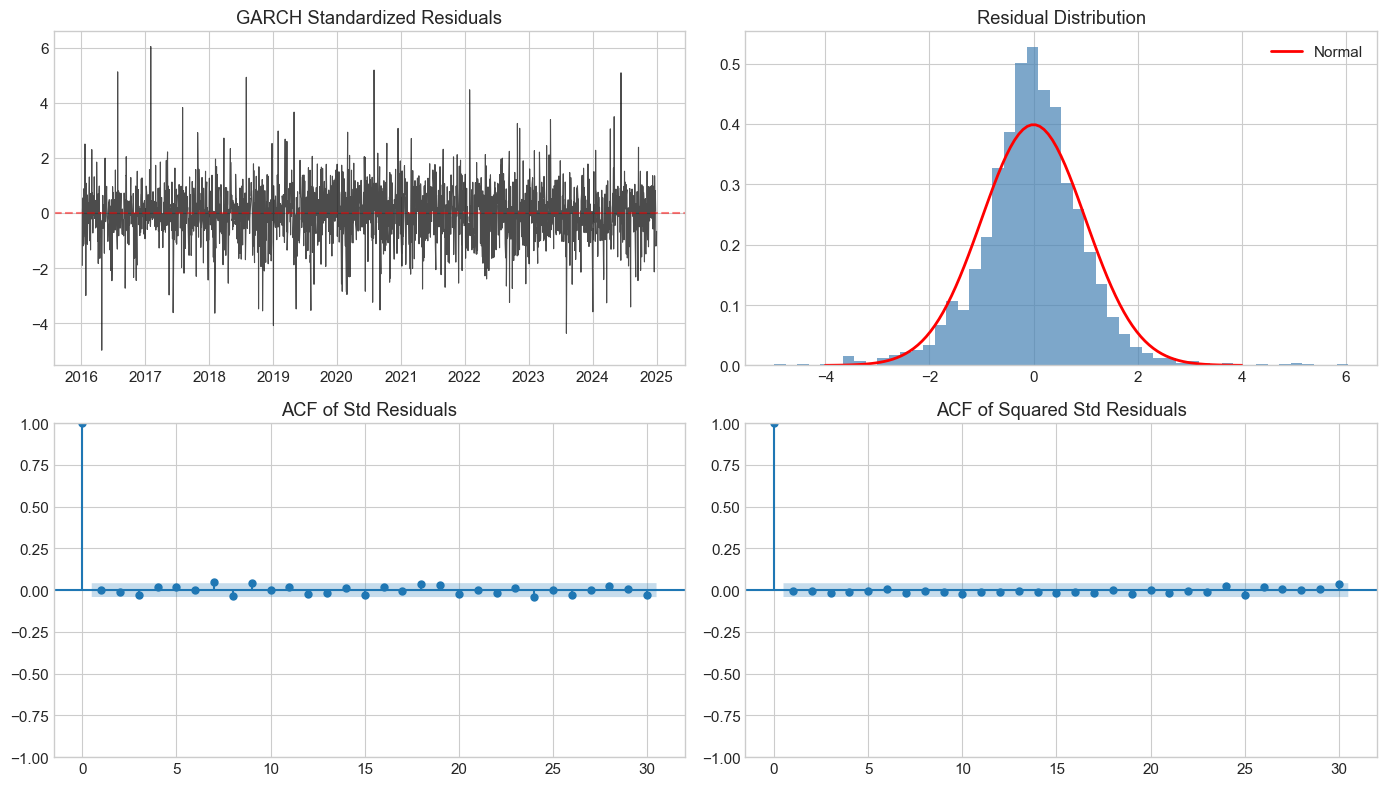

In [112]:
# Diagnostic Plots
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes[0, 0].plot(std_resid.index, std_resid.values, 'k-', alpha=0.7, lw=0.8)
axes[0, 0].axhline(0, color='red', ls='--', alpha=0.5)
axes[0, 0].set_title('GARCH Standardized Residuals')

axes[0, 1].hist(std_resid, bins=50, density=True, alpha=0.7, color='steelblue')
x = np.linspace(-4, 4, 100)
axes[0, 1].plot(x, stats.norm.pdf(x), 'r-', lw=2, label='Normal')
axes[0, 1].set_title('Residual Distribution')
axes[0, 1].legend()

plot_acf(std_resid, lags=30, ax=axes[1, 0], title='ACF of Std Residuals')
plot_acf(std_resid**2, lags=30, ax=axes[1, 1], title='ACF of Squared Std Residuals')

plt.tight_layout()
plt.show()

### A.5: In-Sample Volatility Bands

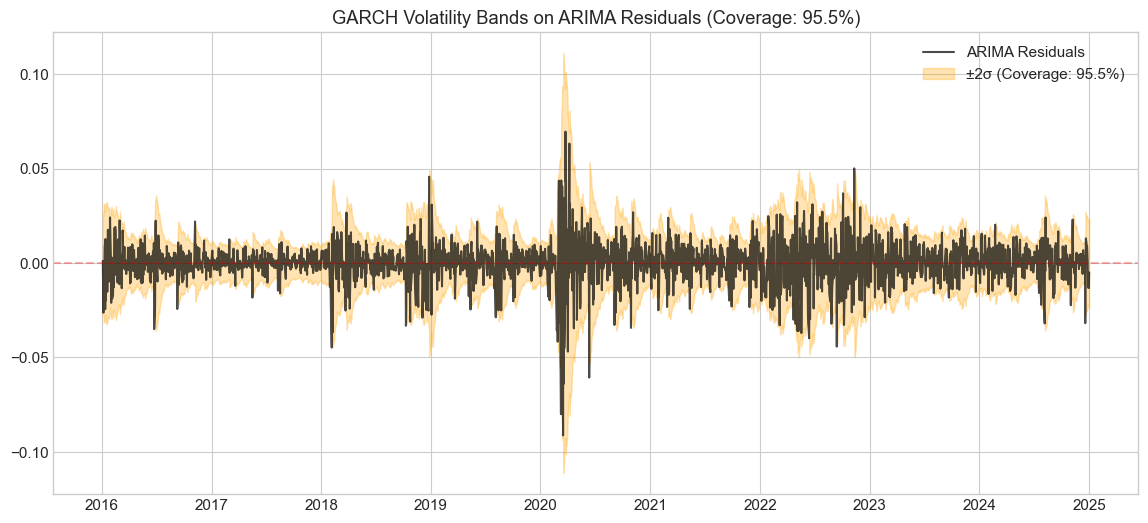

In [31]:
cond_vol = best_garch_fit.conditional_volatility / 100  # Unscale
aligned_resid = arima_resid.iloc[-len(cond_vol):]

inside = (aligned_resid.values > -2*cond_vol.values) & (aligned_resid.values < 2*cond_vol.values)
coverage = inside.mean()

plt.figure(figsize=(14, 6))
plt.plot(aligned_resid.index, aligned_resid.values, 'k-', alpha=0.7, label='ARIMA Residuals')
plt.fill_between(aligned_resid.index, -2*cond_vol.values, 2*cond_vol.values, 
                 alpha=0.3, color='orange', label=f'±2σ (Coverage: {coverage:.1%})')
plt.axhline(0, color='red', ls='--', alpha=0.3)
plt.title(f'GARCH Volatility Bands on ARIMA Residuals (Coverage: {coverage:.1%})')
plt.legend()
plt.show()

### A.6: Walk-Forward Backtest (Two-Step)

In [ ]:
series = modelling_series
train_end = len(series) - TEST_SIZE

arima_garch_forecasts, arima_garch_sigmas, actuals, dates = [], [], [], []
fail_count = 0

last_fc = np.nan
last_sigma = np.nan

for i in tqdm(range(TEST_SIZE), desc="ARIMA-GARCH Backtest"):
    train = series.iloc[:train_end + i]
    actual = series.iloc[train_end + i]
    date = series.index[train_end + i]

    try:
        # 1) Mean model (ensure trend matches your selection)
        arima_fit = ARIMA(train, order=(BEST_P, BEST_D, BEST_Q), trend="n").fit()
        arima_fc = float(arima_fit.forecast(steps=1).iloc[0])

        resid = arima_fit.resid.dropna()

        # 2) Vol model on residuals (no manual *100 scaling)
        am = arch_model(
            resid,
            mean="AR",
            lags=1,
            vol="Garch",
            p=GARCH_P,
            q=GARCH_Q,
            dist=BEST_DIST
        )
        gfit = am.fit(disp="off", show_warning=False)

        fcast = gfit.forecast(horizon=1, reindex=False)
        var1 = float(fcast.variance.values[-1, 0])
        vol_fc = float(np.sqrt(var1))

        last_fc, last_sigma = arima_fc, vol_fc

    except Exception:
        fail_count += 1
        # carry-forward
        arima_fc = last_fc
        vol_fc = last_sigma

    arima_garch_forecasts.append(arima_fc)
    arima_garch_sigmas.append(vol_fc)
    actuals.append(actual)
    dates.append(date)

print(f"Backtest finished. Failures handled: {fail_count}")

ARIMA-GARCH Backtest:   0%|          | 0/56 [00:00<?, ?it/s]

Backtest finished. Failures handled: 0


In [35]:
arima_results = pd.DataFrame({
    'Date': dates,
    'Actual': actuals,
    'ARIMA_GARCH_Pred': arima_garch_forecasts,
    'ARIMA_GARCH_Sigma': arima_garch_sigmas
}).set_index('Date')

ag_mse = mean_squared_error(arima_results['Actual'], arima_results['ARIMA_GARCH_Pred'])
ag_mae = mean_absolute_error(arima_results['Actual'], arima_results['ARIMA_GARCH_Pred'])
ag_dir = np.mean(np.sign(arima_results['Actual']) == np.sign(arima_results['ARIMA_GARCH_Pred']))

print(f"\n=== ARIMA({BEST_P},{BEST_D},{BEST_Q})-GARCH(1,1)-{BEST_DIST} Backtest ===")
print(f"MSE:           {ag_mse:.8f}")
print(f"MAE:           {ag_mae:.8f}")
print(f"Direction Acc: {ag_dir:.2%}")


=== ARIMA(3,0,2)-GARCH(1,1)-skewt Backtest ===
MSE:           0.00006888
MAE:           0.00567398
Direction Acc: 53.57%


In [39]:
mu = np.array(arima_garch_forecasts)
sigma = np.array(arima_garch_sigmas)
y = np.array(actuals)

eps = 1e-12
z = mu / (sigma + eps)

def backtest_threshold(z, y, c, cost=0.0):
    # positions: +1 (Long), -1 (Short), 0 (Flat)
    pos = np.where(z > c, 1, np.where(z < -c, -1, 0))

    strat = pos * y
    turnover = np.abs(np.diff(pos, prepend=0))
    strat_net = strat - cost * turnover

    traded = pos != 0
    dir_acc = np.mean(strat[traded] > 0) if traded.any() else np.nan
    freq = traded.mean()

    return {
        "threshold_c": c,
        "trade_freq": freq,
        "dir_acc_traded": dir_acc,
        "mean_return": strat_net.mean(),
        "volatility": strat_net.std(ddof=1),
        "sharpe": (strat_net.mean() / (strat_net.std(ddof=1) + eps)) * np.sqrt(252),
        "positions": pos
    }



### Threshold Sweep Table and choosing of best threshold 


In [40]:
# --- What it does:
# Runs a threshold sweep, prints a clean metrics table, and selects the best quantile/threshold by Sharpe.

quantiles = [0.60, 0.70, 0.80, 0.90]
results = []

for q in quantiles:
    c = np.quantile(np.abs(z), q)
    res = backtest_threshold(z, y, c, cost=0.0001)
    res["quantile"] = q
    results.append(res)

results_df = pd.DataFrame(results)[
    ["quantile", "threshold_c", "trade_freq", "dir_acc_traded",
     "mean_return", "volatility", "sharpe"]
].sort_values("sharpe", ascending=False)

print("\n=== Threshold Sweep (sorted by Sharpe) ===")
print(results_df.round(4).to_string(index=False))

best_row = results_df.iloc[0]
q_star = float(best_row["quantile"])
c_star = float(best_row["threshold_c"])

print(f"\nSelected threshold: quantile={q_star:.2f}, c={c_star:.4f} (best Sharpe)")


=== Threshold Sweep (sorted by Sharpe) ===
 quantile  threshold_c  trade_freq  dir_acc_traded  mean_return  volatility  sharpe
      0.9       0.1912      0.1071          0.5000      -0.0001      0.0018 -0.4486
      0.8       0.1530      0.1964          0.4545      -0.0004      0.0039 -1.8185
      0.7       0.1204      0.3036          0.4118      -0.0013      0.0058 -3.4611
      0.6       0.0989      0.3929          0.4091      -0.0015      0.0060 -4.0183

Selected threshold: quantile=0.90, c=0.1912 (best Sharpe)


### Next-day action

In [41]:
# --- What it does:
# Creates an action table where today's signal determines NEXT day’s position (no look-ahead),
# and also prints a trades-only subset (non-FLAT days).

pos_raw = np.where(z > c_star, 1, np.where(z < -c_star, -1, 0))

# IMPORTANT: shift by 1 so the decision at time t is applied to return at time t+1
pos_next_day = pd.Series(pos_raw).shift(1).fillna(0).astype(int).to_numpy()

action_map = {1: "LONG", -1: "SHORT", 0: "FLAT"}
actions = pd.Series(pos_next_day).map(action_map)

actions_df = pd.DataFrame({
    "mu_hat": mu,
    "sigma_hat": sigma,
    "z_score": z,
    "position_next_day": pos_next_day,
    "action_next_day": actions,
    "actual_return": y
})

print("\n=== Action Table (next-day aligned) ===")
print(actions_df.head(10).round(4).to_string(index=False))

trades_only_df = actions_df[actions_df["position_next_day"] != 0].copy()
print("\n=== Trades Only (non-FLAT) ===")
print(trades_only_df.head(10).round(4).to_string(index=False))
print(f"\nTrade frequency (realised): {np.mean(pos_next_day != 0):.4f}")


=== Action Table (next-day aligned) ===
 mu_hat  sigma_hat  z_score  position_next_day action_next_day  actual_return
 0.0008     0.0071   0.1117                  0            FLAT         0.0060
-0.0008     0.0067  -0.1200                  0            FLAT         0.0081
-0.0005     0.0075  -0.0624                  0            FLAT        -0.0078
 0.0015     0.0074   0.2073                  0            FLAT         0.0043
-0.0011     0.0071  -0.1535                  1            LONG         0.0001
 0.0003     0.0063   0.0440                  0            FLAT         0.0038
-0.0004     0.0063  -0.0614                  0            FLAT        -0.0017
 0.0005     0.0055   0.0865                  0            FLAT        -0.0005
-0.0001     0.0051  -0.0118                  0            FLAT        -0.0092
 0.0010     0.0063   0.1533                  0            FLAT         0.0022

=== Trades Only (non-FLAT) ===
 mu_hat  sigma_hat  z_score  position_next_day action_next_day  actua

## Combined confidence + vol-targeted sizing + performance table

In [43]:
# --- What it does:
# Converts mu/sigma into a continuous position size using BOTH:
# (i) confidence (z-score) and (ii) volatility targeting, with leverage caps and costs.
# Outputs summary metrics.

def size_confidence_vol_target(mu, sigma, sigma_target=0.01, c=0.5, k=1.0, w_max=2.0):
    """
    w_t = clip( (sigma_target / sigma_t) * f(z_t), -w_max, w_max )
    with f(z) = 0 if |z|<=c else k*(|z|-c)*sign(z)
    """
    eps = 1e-12
    z = mu / (sigma + eps)

    f = np.zeros_like(z)
    mask = np.abs(z) > c
    f[mask] = k * (np.abs(z[mask]) - c) * np.sign(z[mask])

    w = (sigma_target / (sigma + eps)) * f
    return np.clip(w, -w_max, w_max)

# Example hyperparams (tune these on VALIDATION only)
sigma_target = 0.01   # target daily vol (1%)
k = 1.0               # confidence scaling
w_max = 2.0           # leverage cap

w_raw = size_confidence_vol_target(mu, sigma, sigma_target=sigma_target, c=c_star, k=k, w_max=w_max)

# Next-day alignment (apply position decided at t to return at t+1)
w = pd.Series(w_raw).shift(1).fillna(0).to_numpy()

cost = 0.0001  # per unit turnover cost
turnover = np.abs(np.diff(w, prepend=0))
pnl_gross = w * y
pnl_net = pnl_gross - cost * turnover

ann_sharpe = (pnl_net.mean() / (pnl_net.std(ddof=1) + 1e-12)) * np.sqrt(252)

summary = pd.DataFrame([{
    "sigma_target": sigma_target,
    "threshold_c": c_star,
    "k": k,
    "w_max": w_max,
    "trade_freq_nonzero": float(np.mean(np.abs(w) > 0)),
    "mean_return": float(pnl_net.mean()),
    "volatility": float(pnl_net.std(ddof=1)),
    "sharpe": float(ann_sharpe),
}])

print("\n=== Confidence + Vol-Targeted Strategy Summary ===")
print(summary.round(6).to_string(index=False))


=== Confidence + Vol-Targeted Strategy Summary ===
 sigma_target  threshold_c   k  w_max  trade_freq_nonzero  mean_return  volatility    sharpe
         0.01     0.191227 1.0    2.0            0.107143    -0.000007    0.000058 -2.042678


---
# Part B: XGBoost

In [ ]:
N_LAGS = 5
VOL_WINDOW = 21

feature_df = df[['Return']].copy()
for lag in range(1, N_LAGS + 1):
    feature_df[f'lag_{lag}'] = feature_df['Return'].shift(lag)
feature_df['rolling_vol'] = feature_df['Return'].shift(1).rolling(VOL_WINDOW).std()
feature_df['ewma_vol'] = feature_df['Return'].shift(1).ewm(span=VOL_WINDOW).std()
feature_df.dropna(inplace=True)

FEATURE_COLS = [c for c in feature_df.columns if c != 'Return']
X_full = feature_df[FEATURE_COLS]
y_full = feature_df['Return']

print(f"Features: {FEATURE_COLS}")
print(f"Samples: {len(X_full)}")

In [ ]:
train_end = len(X_full) - TEST_SIZE

xgb_forecasts = []
xgb_actuals = []
xgb_dates = []

XGB_PARAMS = {
    'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05,
    'objective': 'reg:squarederror', 'verbosity': 0, 'n_jobs': -1,
    'random_state': RANDOM_SEED
}

for i in tqdm(range(TEST_SIZE), desc="XGBoost Backtest"):
    X_train = X_full.iloc[:train_end + i]
    y_train = y_full.iloc[:train_end + i]
    X_test = X_full.iloc[[train_end + i]]
    y_test = y_full.iloc[train_end + i]
    
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    model = xgb.XGBRegressor(**XGB_PARAMS)
    model.fit(X_train_s, y_train)
    pred = model.predict(X_test_s)[0]
    
    xgb_forecasts.append(pred)
    xgb_actuals.append(y_test)
    xgb_dates.append(X_full.index[train_end + i])

In [ ]:
xgb_results = pd.DataFrame({
    'Date': xgb_dates, 'Actual': xgb_actuals, 'XGB_Pred': xgb_forecasts
}).set_index('Date')

xgb_mse = mean_squared_error(xgb_results['Actual'], xgb_results['XGB_Pred'])
xgb_mae = mean_absolute_error(xgb_results['Actual'], xgb_results['XGB_Pred'])
xgb_dir = np.mean(np.sign(xgb_results['Actual']) == np.sign(xgb_results['XGB_Pred']))

print(f"\n=== XGBoost Backtest ===")
print(f"MSE:           {xgb_mse:.8f}")
print(f"MAE:           {xgb_mae:.8f}")
print(f"Direction Acc: {xgb_dir:.2%}")

---
# Part C: LSTM

In [ ]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

LSTM_CONFIG = {'hidden_size': 32, 'num_layers': 1, 'epochs': 30, 'lr': 0.01, 'seq_length': 10}

def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i-seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

print(f"LSTM Config: {LSTM_CONFIG}")

In [ ]:
lstm_forecasts = []
lstm_actuals = []
lstm_dates = []

SEQ_LEN = LSTM_CONFIG['seq_length']
train_end = len(X_full) - TEST_SIZE

for i in tqdm(range(TEST_SIZE), desc="LSTM Backtest"):
    X_train = X_full.iloc[:train_end + i].values
    y_train = y_full.iloc[:train_end + i].values
    
    scaler_X = StandardScaler()
    X_train_s = scaler_X.fit_transform(X_train)
    X_seq, y_seq = create_sequences(X_train_s, y_train, SEQ_LEN)
    
    if len(X_seq) < 10:
        lstm_forecasts.append(0.0)
        lstm_actuals.append(y_full.iloc[train_end + i])
        lstm_dates.append(X_full.index[train_end + i])
        continue
    
    X_t = torch.tensor(X_seq, dtype=torch.float32)
    y_t = torch.tensor(y_seq, dtype=torch.float32).unsqueeze(1)
    
    model = LSTMNet(X_train.shape[1], LSTM_CONFIG['hidden_size'], LSTM_CONFIG['num_layers'])
    opt = optim.Adam(model.parameters(), lr=LSTM_CONFIG['lr'])
    loss_fn = nn.MSELoss()
    
    model.train()
    for _ in range(LSTM_CONFIG['epochs']):
        opt.zero_grad()
        loss = loss_fn(model(X_t), y_t)
        loss.backward()
        opt.step()
    
    X_test_raw = X_full.iloc[train_end + i - SEQ_LEN + 1 : train_end + i + 1].values
    X_test_s = scaler_X.transform(X_test_raw)
    X_test_t = torch.tensor(X_test_s, dtype=torch.float32).unsqueeze(0)
    
    model.eval()
    with torch.no_grad():
        pred = model(X_test_t).item()
    
    lstm_forecasts.append(pred)
    lstm_actuals.append(y_full.iloc[train_end + i])
    lstm_dates.append(X_full.index[train_end + i])

In [ ]:
lstm_results = pd.DataFrame({
    'Date': lstm_dates, 'Actual': lstm_actuals, 'LSTM_Pred': lstm_forecasts
}).set_index('Date')

lstm_mse = mean_squared_error(lstm_results['Actual'], lstm_results['LSTM_Pred'])
lstm_mae = mean_absolute_error(lstm_results['Actual'], lstm_results['LSTM_Pred'])
lstm_dir = np.mean(np.sign(lstm_results['Actual']) == np.sign(lstm_results['LSTM_Pred']))

print(f"\n=== LSTM Backtest ===")
print(f"MSE:           {lstm_mse:.8f}")
print(f"MAE:           {lstm_mae:.8f}")
print(f"Direction Acc: {lstm_dir:.2%}")

---
# Part D: Consolidated Comparison

In [ ]:
comparison = arima_results[['Actual', 'ARIMA_GARCH_Pred']].copy()
comparison['XGB_Pred'] = xgb_results['XGB_Pred']
comparison['LSTM_Pred'] = lstm_results['LSTM_Pred']
comparison.head()

In [ ]:
def compute_metrics(actual, predicted):
    return {
        'MSE': mean_squared_error(actual, predicted),
        'MAE': mean_absolute_error(actual, predicted),
        'Direction Acc': np.mean(np.sign(actual) == np.sign(predicted))
    }

model_name = f'ARIMA({BEST_P},{BEST_D},{BEST_Q})-GARCH(1,1)-{BEST_DIST}'
metrics = {
    model_name: compute_metrics(comparison['Actual'], comparison['ARIMA_GARCH_Pred']),
    'XGBoost': compute_metrics(comparison['Actual'], comparison['XGB_Pred']),
    'LSTM': compute_metrics(comparison['Actual'], comparison['LSTM_Pred'])
}

metrics_df = pd.DataFrame(metrics).T.sort_values('MSE')

print("=" * 70)
print(f"MODEL COMPARISON: {TICKER} ({TEST_SIZE}-day walk-forward backtest)")
print("=" * 70)
display(metrics_df.round(6))
print(f"\n✓ BEST (MSE): {metrics_df.index[0]}")
print(f"✓ BEST (Direction): {metrics_df.sort_values('Direction Acc', ascending=False).index[0]}")

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
models = ['ARIMA_GARCH_Pred', 'XGB_Pred', 'LSTM_Pred']
titles = [model_name, 'XGBoost', 'LSTM']
colors = ['red', 'green', 'purple']

for ax, m, title, c in zip(axes, models, titles, colors):
    ax.plot(comparison.index, comparison['Actual'], 'k-', label='Actual', alpha=0.8, lw=1.5)
    ax.plot(comparison.index, comparison[m], color=c, ls='--', label=title, alpha=0.8)
    ax.axhline(0, color='gray', ls=':', alpha=0.3)
    ax.set_title(f'{title} vs Actual')
    ax.set_ylabel('Return')
    ax.legend(loc='upper right')
axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for i, metric in enumerate(['MSE', 'MAE', 'Direction Acc']):
    vals = metrics_df[metric].values
    clrs = ['green' if v == (vals.max() if metric == 'Direction Acc' else vals.min()) else 'steelblue' for v in vals]
    axes[i].bar(range(len(metrics_df)), vals, color=clrs)
    axes[i].set_xticks(range(len(metrics_df)))
    axes[i].set_xticklabels(metrics_df.index, rotation=45, ha='right')
    axes[i].set_title(metric)
    for j, v in enumerate(vals):
        axes[i].text(j, v, f'{v:.4f}', ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

---
## Final Summary

In [ ]:
print("=" * 75)
print(f"FINAL REPORT: {TICKER}")
print("=" * 75)
print(f"\nData: {START_DATE} to {END_DATE} ({len(df)} obs)")
print(f"Backtest: Last {TEST_SIZE} days (walk-forward, expanding window)")
print(f"\nARIMA-GARCH Selection (Two-Step):")
print(f"  Series: {'Log Returns' if USE_SERIES == 'log_returns' else 'Differenced Price'}")
print(f"  ARIMA Grid: p∈[0,{MAX_AR}], d={SERIES_D}, q∈[0,{MAX_MA}]")
print(f"  Best ARIMA: ({BEST_P},{BEST_D},{BEST_Q})")
print(f"  GARCH: (1,1) with {BEST_DIST} innovations")
print(f"\n{'Model':<40} {'MSE':<12} {'MAE':<12} {'Dir Acc':<12}")
print("-" * 76)
for m, row in metrics_df.iterrows():
    print(f"{m:<40} {row['MSE']:<12.6f} {row['MAE']:<12.6f} {row['Direction Acc']:<12.2%}")
print("-" * 76)
print(f"\n✓ Winner (MSE):       {metrics_df.index[0]}")
print(f"✓ Winner (Direction): {metrics_df.sort_values('Direction Acc', ascending=False).index[0]}")